# Information Weight Transformer
The information weight transformer is designed to improve the embeddings given by a simple Ngram Vectorizer by taking into account the amount of information that each token provides. It plays a similar role to the Term Frequency - Inverse Document Frequency transform for weighting count vectors, but by performing a calculation which is grounded in Bayesian inference and information theory.

## Example: Distinctive Ingredients from Regional Cuisines
Consider a dataset of recipes, labelled by what regional cuisine they came from, and defined by a list of the ingredients used in the recipe.

In [1]:
import numpy as np
import pandas as pd
from vectorizers.transformers import InformationWeightTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from pathlib import Path
import json
from zipfile import ZipFile

In [2]:
path_recipes = Path("recipes.zip")
with ZipFile(path_recipes) as file_data:
    data = pd.DataFrame(json.loads(file_data.read("train.json")))
with pd.option_context("max_colWidth", 120):
    display(data)

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanzo beans, feta cheese..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, yellow corn meal, mil..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, green chilies, grilled chicken breasts, garlic powder, yellow onion, so..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pepper, onions, garlic paste, milk, butter, salt, lemon juice, water, ch..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, warm water, large eggs, all-purpose flour, whole wheat flour, cooking ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, broccoli florets, rotini, pitted black olives, Kraft Grated Parmesan Ch..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starter, flour, hot tea, sugar, ground nutmeg, salt, ground cinnamon, milk, ..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garlic, steamed white rice, baking powder, corn starch, dark soy sauce, kos..."


We can count-vectorize the ingredients, obtaining a vector $x_i$ for each recipe, and we can get a count-vector $X_c$ for each type of cuisine by summing together the vectors corresponding to all recipes in the cuisine $c$.

Let us take the convention that $X_c$ is a row vector; then it's $i$th entry represents the number of times that ingredient $i$ was used in cuisine $c$'s recipes. We can find the largest entries of $X_c$ to get the most common ingredients in a given cuisine:

In [3]:
tokens = []
for i, idno in enumerate(data['id'].to_list()):
    tokens_i = ''.join(x.replace(" ","_").replace("-","_")+' ' for x in list(data['ingredients'].iloc[i]))
    tokens.append(tokens_i)
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(tokens)

In [4]:
cuisine_array = np.array(data['cuisine'].to_list())
cuisines = np.unique(cuisine_array)
n_cuisines = np.size(cuisines)
cookbook_vectors = np.zeros((n_cuisines, np.shape(vectors)[1]))
keywords_freq = []
for k, cuisine in enumerate(cuisines):
    idx = (cuisine_array == cuisine).nonzero()
    cookbook_vectors[k] = np.sum(vectors[idx], axis=0)
    sort_ = np.argsort(cookbook_vectors[k])
    cuisine_str = ''
    for idx in sort_[-3:]:
        word=vectorizer.get_feature_names_out()[idx]
        cuisine_str += word.capitalize().replace("_"," ") + ", "
    keywords_freq.append(cuisine_str)
df = pd.DataFrame()
df['Cuisine'] = [x.capitalize() for x in cuisines]
df['Most Frequent'] = keywords_freq
df

,Cuisine,Most Frequent
0,Brazilian,"Olive oil, Onions, Salt,"
1,British,"Butter, All purpose flour, Salt,"
2,Cajun_creole,"Garlic, Onions, Salt,"
3,Chinese,"Salt, Sesame oil, Soy sauce,"
4,Filipino,"Water, Garlic, Salt,"
5,French,"All purpose flour, Sugar, Salt,"
6,Greek,"Dried oregano, Olive oil, Salt,"
7,Indian,"Garam masala, Onions, Salt,"
8,Irish,"Butter, All purpose flour, Salt,"
9,Italian,"Garlic cloves, Olive oil, Salt,"


These most frequent words are not very good at distinguishing the cuisines, because there are some ingredients that are just too universally common. For example, *salt* appears in the top 3 for every cuisine except Korean! 

To obtain more distinctive words, we can try to weight the words according to their relative frequencies in each document. This is the working principle behind Term Frequency - Inverse Document Frequency (TF-IDF) weighting. Let's try TF-IDF and Information Weighting and see what distinguishing words we obtain:

In [6]:
## Information Weighting:
IWT = InformationWeightTransformer()
iwt_vectors = IWT.fit_transform(vectors,y=data['cuisine'].to_list())
cookbook_vectors_iwt = np.zeros((n_cuisines, np.shape(vectors)[1]))
keywords_iwt = []

for k, cuisine in enumerate(cuisines):
    idx = (cuisine_array == cuisine).nonzero()
    cookbook_vectors_iwt[k] = np.sum(iwt_vectors[idx], axis=0)
for k, cuisine in enumerate(cuisines):
    sort_ = np.argsort(cookbook_vectors_iwt[k])
    cuisine_str = ''
    for idx in sort_[-3:]:
        word=vectorizer.get_feature_names_out()[idx]
        cuisine_str += word.capitalize().replace("_"," ") + ", "
    keywords_iwt.append(cuisine_str)

## TF-IDF Weighting:
TFIDF = TfidfTransformer()
tfidf_vectors = TFIDF.fit_transform(vectors)
cookbook_vectors_tfidf= np.zeros((n_cuisines, np.shape(vectors)[1]))
for k, cuisine in enumerate(cuisines):
    idx = (cuisine_array == cuisine).nonzero()
    cookbook_vectors_tfidf[k] = np.sum(tfidf_vectors[idx], axis=0)

keywords_tfidf = []
for k, cuisine in enumerate(cuisines):
    sort_ = np.argsort(cookbook_vectors_tfidf[k])
    cuisine_str = ''
    for idx in sort_[-3:]:
        word=vectorizer.get_feature_names_out()[idx]
        cuisine_str += word.capitalize().replace("_"," ") + ", "
    keywords_tfidf.append(cuisine_str)


df['TF-IDF'] = keywords_tfidf
df['Info Weight'] = keywords_iwt
df

/home/kdruscit/.conda/envs/sklearn/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


,Cuisine,Most Frequent,TF-IDF,Info Weight
0,Brazilian,"Olive oil, Onions, Salt,","Sweetened condensed milk, Lime, Cachaca,","Chocolate sprinkles, Açai, Cachaca,"
1,British,"Butter, All purpose flour, Salt,","Salt, All purpose flour, Milk,","Beef drippings, Suet, Stilton cheese,"
2,Cajun_creole,"Garlic, Onions, Salt,","Onions, Green bell pepper, Cajun seasoning,","Creole seasoning, Andouille sausage, Cajun sea..."
3,Chinese,"Salt, Sesame oil, Soy sauce,","Corn starch, Sesame oil, Soy sauce,","Shaoxing wine, Soy sauce, Sesame oil,"
4,Filipino,"Water, Garlic, Salt,","Water, Garlic, Soy sauce,","Calamansi juice, Fish sauce, Soy sauce,"
5,French,"All purpose flour, Sugar, Salt,","All purpose flour, Salt, Unsalted butter,","Grated gruyère cheese, Cognac, Gruyere cheese,"
6,Greek,"Dried oregano, Olive oil, Salt,","Feta cheese, Olive oil, Feta cheese crumbles,","Greek seasoning, Feta cheese, Feta cheese crum..."
7,Indian,"Garam masala, Onions, Salt,","Ground turmeric, Salt, Garam masala,","Cumin seed, Ground turmeric, Garam masala,"
8,Irish,"Butter, All purpose flour, Salt,","Salt, All purpose flour, Butter,","Irish cream liqueur, Guinness beer, Irish whis..."
9,Italian,"Garlic cloves, Olive oil, Salt,","Salt, Grated parmesan cheese, Olive oil,","Shredded mozzarella cheese, Ricotta cheese, Gr..."


Using the advanced eyeball test, we can see that the TF-IDF and IWT weighted words are much more distinctive of the various cuisines. However the TF-IDF weighting still leaves a lot of redundancy, such as salt still showing up for half of the cuisines. The information weight transform, on the other hand, has distinguished the cuisines much more, and we see some well-known associations like Kimchi in Korean cuisine or Feta in Greek cuisine.


## Theoretical Explanation
What is the Information Weight Transform actually doing? It is weighting each column (word) by the information that an observation of that column conveys relative to the baseline probability. Suppose you have an array of vectors $A$ so that $A[d]$ is a row vector recording the word counts of document $d$. First, a *baseline* probability distribution over the set of documents is computed by dividing the length of each document by the total number of words in the corpus.
$$P_0(d) = \left(\sum_{i=0}^{N} A[d]_i\right / \left(\sum_{i=0}^{N}\sum_{d} A[d]_i\right)$$
If one picks a random word $w$ from the corpus, the baseline probability distribution $P_0$ is a Bayesian prior for which document the word came from. However, if we look at the word $w$, we can update to a posterior distribution $P'(d) = P(d|w)$ determined by the count data. The *information gain* from an observation of the word $w$ is the relative entropy, or Kullback-Leibler distribution,
$$K(w) = K(P',P_0) = \sum_{d} P(d|w) \log\left(\frac{P(d|w)}{P_0(d)}\right).$$
The information weight transform assigns a weight of $K(w)$ to the column of the array $A$ corresponding to the count of word $w$.

For example, let us first plot the baseline probability for the recipe data. We'll again aggregate along the 'Cuisine' axis.

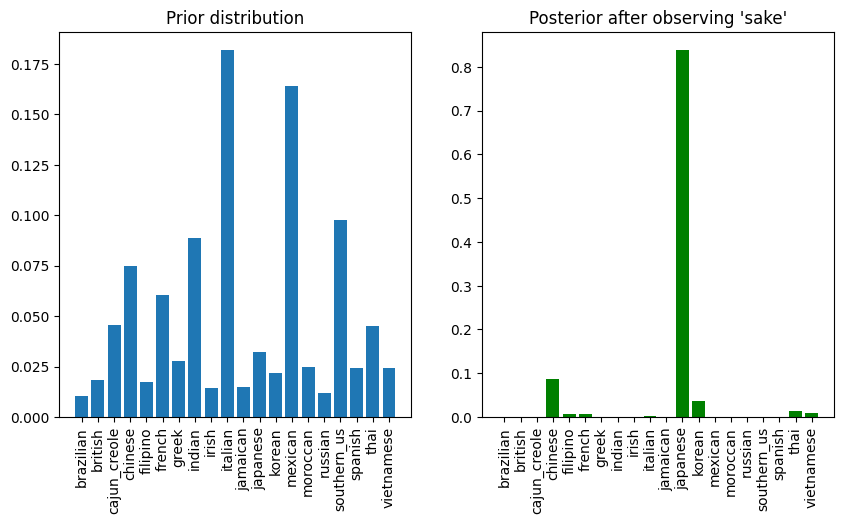

In [7]:
import matplotlib.pyplot as plt
baseline_counts = np.squeeze(np.array(cookbook_vectors.sum(axis=1)))
baseline_probabilities = baseline_counts / baseline_counts.sum()
N_data = np.shape(cookbook_vectors)[0]

word_index = vectorizer.vocabulary_['sake']
observed_counts = cookbook_vectors[:,word_index]
observed_probabilities = observed_counts / observed_counts.sum()

fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(10, 5)

ax1.bar(np.arange(N_data), baseline_probabilities, tick_label=cuisines)
plt.sca(ax1)
plt.title("Prior distribution")
plt.xticks(rotation='vertical')
#ax1.set_ylim(0,0.5)

ax2.bar(np.arange(N_data), observed_probabilities, tick_label=cuisines,color='g')
plt.sca(ax2)
plt.title("Posterior after observing 'sake'")
plt.xticks(rotation='vertical')
#ax2.set_ylim(0,0.5)

plt.show()

## Parameters
One benefit of the information weight transform is it's lack of hyperparameters that need to be chosen. The InformationWeightTransformer class only has three keyword arguments:

`approximate_prior`-         Whether to approximate weights based on the Bayesian prior or perform
        exact computations. Approximations are much faster especially for very
        large or very sparse datasets.

`prior_strength` -         How strongly to weight the prior when doing a Bayesian update to
        derive a model based on observed counts of a column.

`y` -         If supervised target labels are available, these can be used to define distributions
        over the target classes rather than over rows, allowing weights to be
        supervised and target based. If None then unsupervised weighting is used.